In [119]:
from aipy.coord import rot_m, xyz2thphi
import healpy
import numpy as np
import jax
import jax.numpy as jnp
import optax

In [122]:
def rot_m(ang, vec):
    """Return 3x3 matrix defined by rotation by 'ang' around the
    axis 'vec', according to the right-hand rule.  Both can be vectors,
    returning a vector of rotation matrices.  Rotation matrix will have a
    scaling of |vec| (i.e. normalize |vec|=1 for a pure rotation)."""
    c = jnp.cos(ang); s = jnp.sin(ang); C = 1-c
    x,y,z = vec[...,0], vec[...,1], vec[...,2]
    xs,ys,zs = x*s, y*s, z*s
    xC,yC,zC = x*C, y*C, z*C
    xyC,yzC,zxC = x*yC, y*zC, z*xC
    rm = jnp.array([[x*xC+c, xyC-zs, zxC+ys],
                   [xyC+zs, y*yC+c, yzC-xs],
                   [zxC-ys, yzC+xs, z*zC+c]], dtype=jnp.double)
    if rm.ndim > 2:
        axes = list(range(rm.ndim))
        return rm.transpose(axes[-1:] + axes[:-1])
    else:
        return rm

def xyz2thphi(xyz):
    """Convert xyz vectors (x,y,z along first axis) into angles theta
    (from z axis), phi (counter-clockwise around z, 0 at x axis)."""
    x,y,z = xyz
    phi = jnp.arctan2(y, x)
    th = jnp.arctan2(jnp.sqrt(x**2+y**2),z)
    # if jnp.ma.isMA(x):
    #     try:
    #         return jnp.ma.array([th.filled(0),phi.filled(0)],
    #             mask=[x.mask,x.mask], dtype=jnp.double)
    #     except(jnp.core.ma.MAError):
    #         return jnp.ma.array([th,phi], dtype=jnp.double)
    return jnp.array([th,phi], dtype=jnp.double)

In [288]:
dtype_r = jnp.float32
DEFAULT_NSIDE = 32
DEFAULT_NPIX = healpy.nside2npix(DEFAULT_NSIDE)
px = jnp.arange(DEFAULT_NPIX)
th, phi = healpy.pix2ang(DEFAULT_NSIDE, px)
DEFAULT_BEAM_TH = jnp.cos(th)**2 * jnp.cos(phi)**2
DEFAULT_BEAM_PHI = jnp.cos(th)**2 * jnp.sin(phi)**2

class RotatingAntenna:
    def __init__(self, beam_th=DEFAULT_BEAM_TH, beam_phi=DEFAULT_BEAM_PHI):
        self.nside = healpy.npix2nside(beam_th.size)
        self.pwr_beam_th = beam_th
        self.pwr_beam_phi = beam_phi
        self.el_axis = jnp.array([1, 0, 0], dtype=dtype_r)
        self.az_axis = jnp.array([0, 0, 1], dtype=dtype_r)

    def rotation(self, az, el):
        R_az = rot_m(az, self.az_axis)
        R_el = rot_m(el, self.el_axis)
        return R_el @ R_az

    def r_hat(self, th, phi):
        shape = th.shape
        r_hat = jnp.empty(shape + (3,), dtype=dtype_r)
        # r_hat[..., 2] = jnp.cos(th)
        r_hat = r_hat.at[..., 2].set(jnp.cos(th))
        xy = jnp.sin(th)
        # r_hat[..., 0] = jnp.cos(phi) * xy
        # r_hat[..., 1] = jnp.sin(phi) * xy
        r_hat = r_hat.at[..., 0].set(jnp.cos(phi) * xy)
        r_hat = r_hat.at[..., 1].set(jnp.sin(phi) * xy)
        return r_hat
        
    def phi_hat(self, th, phi):
        r_hat = self.r_hat(th, phi)
        phi_hat = jnp.cross(jnp.array([0, 0, 1]), r_hat)
        phi_hat /= jnp.linalg.norm(phi_hat, axis=-1, keepdims=True)
        return phi_hat

    def th_hat(self, th, phi):
        r_hat = self.r_hat(th, phi)
        phi_hat = self.phi_hat(th, phi)
        return jnp.cross(r_hat, phi_hat)

    def ang2pix(self, th, phi):
        return healpy.ang2pix(self.nside, th, phi)
    
    def sample_beam_th(self, th, phi):
        px = self.ang2pix(th, phi)
        return self.pwr_beam_th[px]
        
    def sample_beam_phi(self, th, phi):
        px = self.ang2pix(th, phi)
        return self.pwr_beam_phi[px]

    def power_transmitter(self, tx_ant, az, el):
        rot_m = self.rotation(az, el)
        th_tx, phi_tx = tx_ant.heading_thphi(rot_m)
        E_tx_rot = tx_ant.E_rotated(rot_m)
        px = self.ang2pix(th_tx, phi_tx)
        th_hat = self.th_hat(th_tx, phi_tx)
        phi_hat = self.phi_hat(th_tx, phi_tx)
        E_tx_th = jnp.dot(E_tx_rot, th_hat)
        E_tx_phi = jnp.dot(E_tx_rot, phi_hat)
        P_rx_th = self.pwr_beam_th[px] * E_tx_th**2
        P_rx_phi = self.pwr_beam_phi[px] * E_tx_phi**2
        P_rx = P_rx_th + P_rx_phi
        return P_rx
    
    def power_transmitter_jax(self, tx_ant, rot_m, th_tx, phi_tx, px):
        # rot_m = self.rotation(az, el)
        # th_tx, phi_tx = tx_ant.heading_thphi(rot_m)
        E_tx_rot = tx_ant.E_rotated(rot_m)
        # px = self.ang2pix(th_tx, phi_tx)
        th_hat = self.th_hat(th_tx, phi_tx)
        phi_hat = self.phi_hat(th_tx, phi_tx)
        E_tx_th = jnp.dot(E_tx_rot, th_hat)
        E_tx_phi = jnp.dot(E_tx_rot, phi_hat)
        P_rx_th = self.pwr_beam_th[px] * E_tx_th**2
        P_rx_phi = self.pwr_beam_phi[px] * E_tx_phi**2
        P_rx = P_rx_th + P_rx_phi
        return P_rx
    def power_transmitter_jax_pure(self, tx_ant, rot_m, th_tx, phi_tx, px,
                                   pwr_beam_th, pwr_beam_phi):
        # Same geometry as before
        E_tx_rot = tx_ant.E_rotated(rot_m)
        th_hat   = self.th_hat(th_tx, phi_tx)
        phi_hat  = self.phi_hat(th_tx, phi_tx)
    
        E_tx_th  = jnp.dot(E_tx_rot, th_hat)
        E_tx_phi = jnp.dot(E_tx_rot, phi_hat)
    
        # px may be a traced scalar — make sure it’s an int and use dynamic indexing
        px = jax.lax.convert_element_type(px, jnp.int32)
        g_th  = jax.lax.dynamic_index_in_dim(pwr_beam_th,  px, axis=0, keepdims=False)
        g_phi = jax.lax.dynamic_index_in_dim(pwr_beam_phi, px, axis=0, keepdims=False)
    
        P_rx_th  = g_th  * (E_tx_th  ** 2)
        P_rx_phi = g_phi * (E_tx_phi ** 2)
        return P_rx_th + P_rx_phi        

class TransmitterAntenna:
    def __init__(self, E1=1.0, E2=0.0, heading_top=jnp.array([0, 0, -1], dtype=dtype_r)):
        self.E1 = E1
        self.E2 = E2
        self.heading_top = heading_top
        self.ax1_top = jnp.array([1, 0, 0], dtype=dtype_r)
        self.ax2_top = jnp.array([0, 1, 0], dtype=dtype_r)

    def E_top(self):
        return self.E1 * self.ax1_top + self.E2 * self.ax2_top

    def E_rotated(self, ant_rot_m):
        irot_m = jnp.linalg.inv(ant_rot_m)
        return irot_m @ self.E_top()

    def heading_rotated(self, ant_rot_m):
        irot_m = jnp.linalg.inv(ant_rot_m)
        return irot_m @ self.heading_top
        
    def heading_thphi(self, ant_rot_m):
        heading_rot = self.heading_rotated(ant_rot_m)
        return xyz2thphi(heading_rot)

In [133]:
tx_ant = TransmitterAntenna()
rot_ant = RotatingAntenna()
r = rot_ant.rotation(jnp.deg2rad(30), jnp.deg2rad(0))
E_rot = tx_ant.E_rotated(r)
np.testing.assert_almost_equal(E_rot[0], np.sqrt(3) / 2, 5)
np.testing.assert_almost_equal(E_rot[1], -1 / 2, 5)
np.testing.assert_almost_equal(E_rot[2], 0, 5)

/tmp/ipykernel_236399/3751696831.py:11: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  rm = jnp.array([[x*xC+c, xyC-zs, zxC+ys],


In [134]:
r = rot_ant.rotation(np.deg2rad(30), np.deg2rad(0))
np.testing.assert_allclose(tx_ant.heading_rotated(r), np.array([0, 0, -1], dtype=dtype_r), atol=1e-5)
r = rot_ant.rotation(np.deg2rad(0), np.deg2rad(180))
np.testing.assert_allclose(tx_ant.heading_rotated(r), np.array([0, 0, 1], dtype=dtype_r), atol=1e-5)
r = rot_ant.rotation(np.deg2rad(90), np.deg2rad(-90))
np.testing.assert_allclose(tx_ant.heading_rotated(r), np.array([1, 0, 0], dtype=dtype_r), atol=1e-5)

/tmp/ipykernel_236399/3751696831.py:11: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  rm = jnp.array([[x*xC+c, xyC-zs, zxC+ys],


In [135]:
phi_hat = rot_ant.phi_hat(np.deg2rad(90), np.deg2rad(0))
th_hat = rot_ant.th_hat(np.deg2rad(90), np.deg2rad(0))
np.testing.assert_allclose(phi_hat, np.array([0, 1, 0], dtype=dtype_r), atol=1e-5)
np.testing.assert_allclose(th_hat, np.array([0, 0, 1], dtype=dtype_r), atol=1e-5)

In [136]:
nside = 64
npix = healpy.nside2npix(nside)
px = np.arange(npix)
th, phi = healpy.pix2ang(nside, px)
r_hat = rot_ant.r_hat(th, phi)
phi_hat = rot_ant.phi_hat(th, phi)
th_hat = rot_ant.th_hat(th, phi)
np.testing.assert_allclose(np.linalg.norm(r_hat, axis=-1), 1, atol=1e-5)
np.testing.assert_allclose(np.linalg.norm(phi_hat, axis=-1), 1, atol=1e-5)
np.testing.assert_allclose(np.linalg.norm(th_hat, axis=-1), 1, atol=1e-5)
np.testing.assert_allclose(phi_hat[..., 2], 0, atol=1e-5)
assert np.all(th_hat[..., 2] >= 0)
#healpy.mollview(th_hat[..., 2], min=-1, max=1, cmap='bwr')

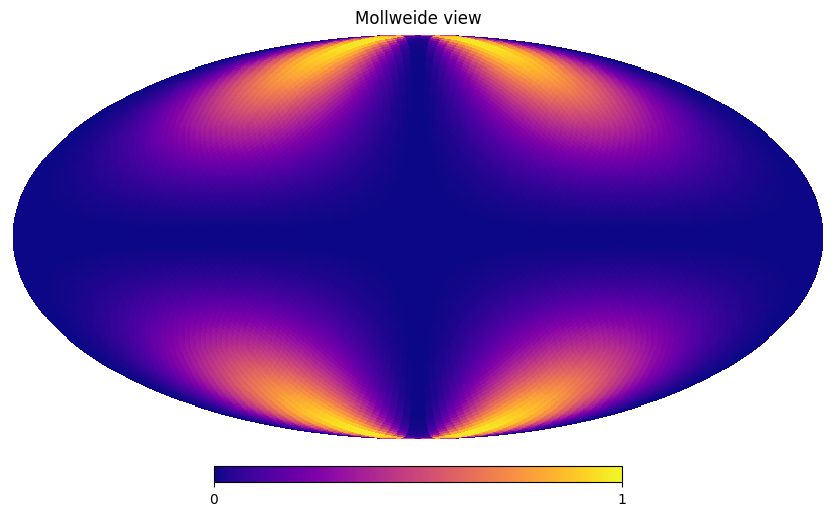

In [137]:
beam_th = rot_ant.sample_beam_phi(th, phi)
healpy.mollview(beam_th, min=0, max=1, cmap='plasma')

In [138]:
P_rx = rot_ant.power_transmitter(tx_ant, jnp.deg2rad(0), jnp.deg2rad(90))
np.testing.assert_almost_equal(P_rx, 0, 3)
P_rx = rot_ant.power_transmitter(tx_ant, np.deg2rad(0), np.deg2rad(45))
np.testing.assert_almost_equal(P_rx, 0.5, 3)
P_rx

/tmp/ipykernel_236399/3751696831.py:11: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  rm = jnp.array([[x*xC+c, xyC-zs, zxC+ys],
/tmp/ipykernel_236399/3751696831.py:32: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.array([th,phi], dtype=jnp.double)


Array(0.49955064, dtype=float32)

In [85]:


az_range_deg = jnp.deg2rad(jnp.linspace(0.0, 360.0, 72, endpoint=False)) # orientation of the box, NOT the beam's theta and phi
el_range_deg = jnp.deg2rad(jnp.linspace(0.0, 360.0, 72, endpoint=False))
el = []
az = []
el_axs = el_range_deg.copy()
for av in az_range_deg:
    for ev in el_axs:
        el.append(ev)
        az.append(av)
    el_axs = el_axs[::-1]
el = jnp.array(el)
az = jnp.array(az)

fake_Ps = jnp.linspace(0, el.shape[0], el.shape[0], endpoint=False)
fake_Ps.shape

(5184,)

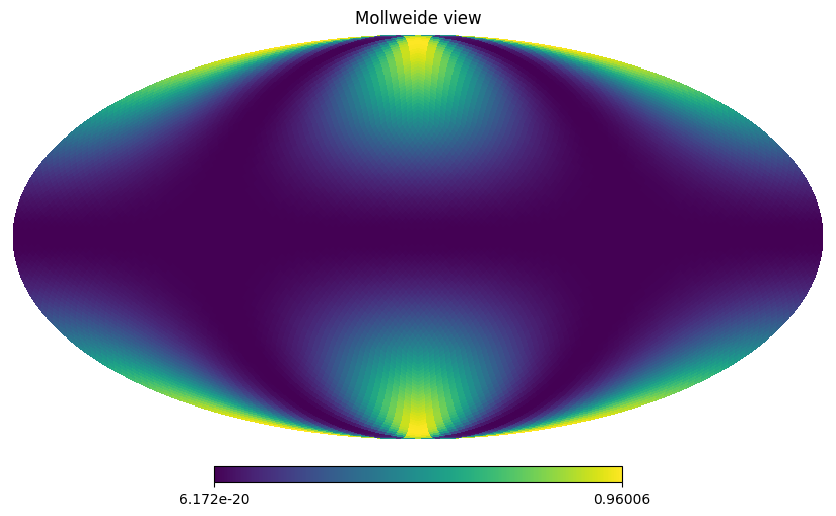

In [86]:
healpy.mollview(rot_ant.pwr_beam_th)

## Starting simple: 1 P, el, and az

In [70]:
test_el.dtype

dtype('float32')

In [214]:
ind = 2000
test_P = fake_Ps[ind]
test_el = el[ind]
test_az = az[ind]
tx_ant_test = TransmitterAntenna(E1=1, E2=0)
rx_ant_test = RotatingAntenna()
# print(rx_ant_test.pwr_beam_th)
# print(rx_ant_test.pwr_beam_th)

r = rx_ant_test.rotation(test_az, test_el)
th_tx, phi_tx = tx_ant_test.heading_thphi(r)
px = rx_ant_test.ang2pix(th_tx, phi_tx)
# print(rx_ant_test.pwr_beam_th)
print(px)

def loss(W):
    e1, e2, th, ph = W
    tx_ant_test = TransmitterAntenna(E1=e1, E2=e2)
    rx_ant_test.pwr_beam_th = rx_ant_test.pwr_beam_th.at[px].set(th)
    rx_ant_test.pwr_beam_phi = rx_ant_test.pwr_beam_phi.at[px].set(ph)
    model = rx_ant_test.power_transmitter_jax(tx_ant_test, r, th_tx, phi_tx, px)
    return jnp.mean(model - test_P)**2

def make_step(optimizer):
    @jax.jit
    def step(W, opt_state):
        l, grads = jax.value_and_grad(loss)(W)
        updates, opt_state = optimizer.update(grads, opt_state, W)
        W = optax.apply_updates(W, updates)
        return W, opt_state, l
    return step

opt = optax.adam(1e-2)
e1, e2, th, ph = [1.0, 5.0, 2.0, 0.0]
W = jnp.array([e1, e2, th, ph])
opt_state = opt.init(W)
step = make_step(opt)

for i in range(2000):
    W, opt_state, cur_loss = step(W, opt_state)
    if (i+1) % 400 == 0:
        print(f"step {i+1:4d} | loss {cur_loss:.6f}")

/tmp/ipykernel_236399/3751696831.py:11: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  rm = jnp.array([[x*xC+c, xyC-zs, zxC+ys],
/tmp/ipykernel_236399/3751696831.py:32: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.array([th,phi], dtype=jnp.double)


7792
step  400 | loss 828451.937500
step  800 | loss 13.204423
step 1200 | loss 0.000069
step 1600 | loss 0.000059
step 2000 | loss 0.000036


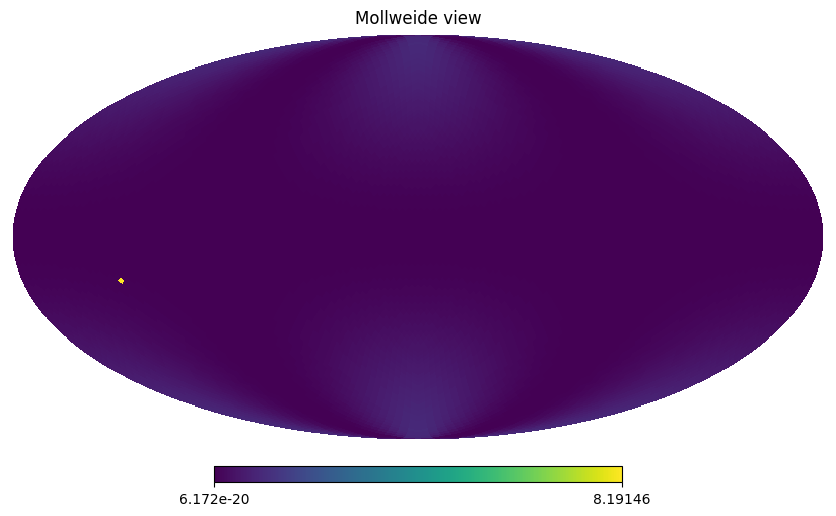

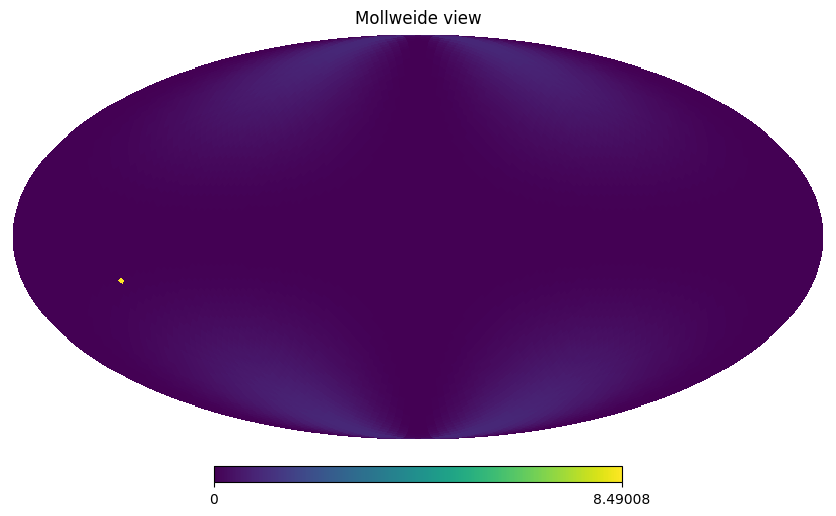

In [213]:
default_th = DEFAULT_BEAM_TH.copy()
default_ph = DEFAULT_BEAM_PHI.copy()

default_th = default_th.at[px].set(W[2])
default_ph = default_ph.at[px].set(W[3])

healpy.mollview(default_th)
healpy.mollview(default_ph)

## Now any P, el, and az

In [166]:
el.shape[0]

5184

In [272]:
stop = 500
rx_ant_test = RotatingAntenna()
tx_ant_test = TransmitterAntenna(E1=1, E2=0)

def px_th_ph(rx, tx, az, el):
    shape_len = el.shape[0]
    pxs = jnp.zeros(shape_len)
    th_txs = jnp.zeros(shape_len)
    phi_txs = jnp.zeros(shape_len)
    rs = jnp.zeros((shape_len, 3, 3))
    for i in range(shape_len):
        r = rx.rotation(az[i], el[i])
        th_tx, phi_tx = tx.heading_thphi(r)
        px = rx_ant_test.ang2pix(th_tx, phi_tx)
        pxs = pxs.at[i].set(px)
        th_txs = th_txs.at[i].set(th_tx)
        phi_txs = phi_txs.at[i].set(phi_tx)
        rs = rs.at[i].set(r)
        if (i + 1) % 100 == 0:
            print(f'Collecting Coords: {i+1}/{shape_len}')
    print('Finished Calculating Coords')
    return rs, th_txs, phi_txs, pxs

# rs, th_txs, phi_txs, pxs = px_th_ph(rx_ant_test, tx_ant_test, az[:stop], el[:stop])

def beam_finder(tx, rx, P, az, el, guesses):
    coords = px_th_ph(rx, tx, az, el)
    k = 3 
    coords = tuple( x.astype(jnp.int32) if i == k else x
                for i, x in enumerate(coords) )
    pwr_beam_th = rx.pwr_beam_th.copy()
    pwr_beam_ph = rx.pwr_beam_phi.copy()
    
    def loss(W, P, coord, pbt, pbp):
        e1, e2, th, ph = W
        r, th_tx, phi_tx, px = coord
        tx_ant_test = TransmitterAntenna(E1=e1, E2=e2)
        # pwr_beam_th = rx_ant_test.pwr_beam_th
        # pwr_beam_ph = rx_ant_test.pwr_beam_phi
        pbt = pbt.at[px].set(th)
        pbp = pbp.at[px].set(ph)
        # rx_ant_test.pwr_beam_th = rx_ant_test.pwr_beam_th.at[px].set(th)
        # rx_ant_test.pwr_beam_phi = rx_ant_test.pwr_beam_phi.at[px].set(ph)
        model = rx_ant_test.power_transmitter_jax(tx, r, th_tx, phi_tx, px)
        return jnp.mean(model - P)**2
    
    def make_step(optimizer):
        @jax.jit
        def step(W, P, coord, pbt, pbp, opt_state):
            l, grads = jax.value_and_grad(loss)(W, P, coord, pbt, pbp)
            updates, opt_state = optimizer.update(grads, opt_state, W)
            W = optax.apply_updates(W, updates)
            return W, opt_state, l
        return step
    
    opt = optax.adam(1e-2)
    # e1, e2, th, ph = guesses
    W = guesses
    Ws = jnp.zeros_like(W)
    for j in range(el.shape[0]):
        w = W[:, j]
        opt_state = opt.init(w)
        step = make_step(opt)
        coords_j = jax.tree_map(lambda x: x[j], coords)
        for i in range(500):
            w, opt_state, cur_loss = step(w, P[j], coords_j, pwr_beam_th, pwr_beam_ph, opt_state)
            if (i+1) % 1000 == 0:
                print(f"step {i+1:4d} | loss {cur_loss:.6f}")
        print(f'got through {j}')
        Ws = Ws.at[:, j].set(w)
    return Ws
        

In [273]:
g_e1 = jnp.ones(el.shape[0]) * 2
g_e2 = jnp.ones(el.shape[0]) * 0
g_th = jnp.ones(el.shape[0])
g_ph = jnp.ones(el.shape[0])
g_W = jnp.stack((g_e1, g_e2, g_th, g_ph), axis=0)
beam_map = beam_finder(tx_ant_test, rx_ant_test, fake_Ps[:stop], az[:stop], el[:stop], g_W[:, :stop])
beam_map.shape

/tmp/ipykernel_236399/3751696831.py:11: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  rm = jnp.array([[x*xC+c, xyC-zs, zxC+ys],
/tmp/ipykernel_236399/3751696831.py:32: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.array([th,phi], dtype=jnp.double)


Finished Calculating Coords
got through 0
got through 1
got through 2
got through 3
got through 4
got through 5
got through 6
got through 7
got through 8
got through 9
got through 10
got through 11
got through 12
got through 13
got through 14
got through 15
got through 16
got through 17
got through 18
got through 19
got through 20
got through 21
got through 22
got through 23
got through 24
got through 25
got through 26
got through 27
got through 28
got through 29
got through 30
got through 31
got through 32
got through 33
got through 34
got through 35
got through 36
got through 37
got through 38
got through 39
got through 40
got through 41
got through 42
got through 43
got through 44
got through 45
got through 46
got through 47
got through 48
got through 49
got through 50
got through 51
got through 52
got through 53
got through 54
got through 55
got through 56
got through 57
got through 58
got through 59
got through 60
got through 61
got through 62
got through 63
got through 64
got thr

(4, 500)

/tmp/ipykernel_236399/3751696831.py:11: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  rm = jnp.array([[x*xC+c, xyC-zs, zxC+ys],
/tmp/ipykernel_236399/3751696831.py:32: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.array([th,phi], dtype=jnp.double)


Finished Calculating Coords


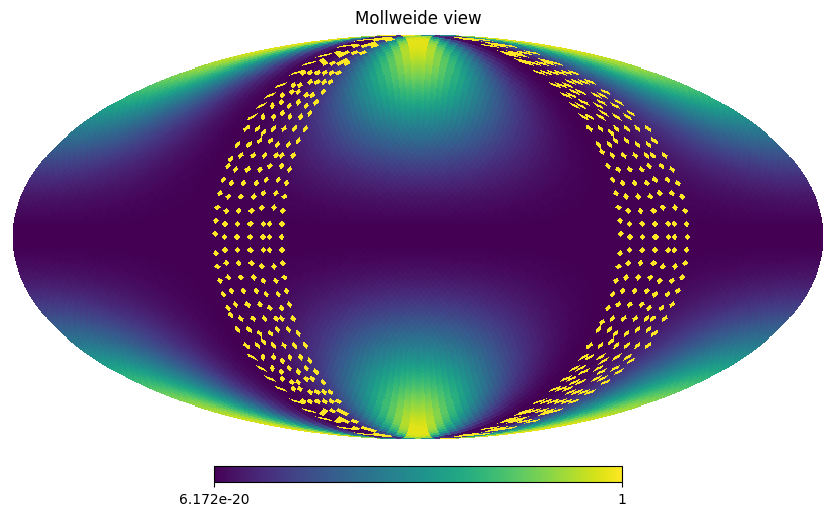

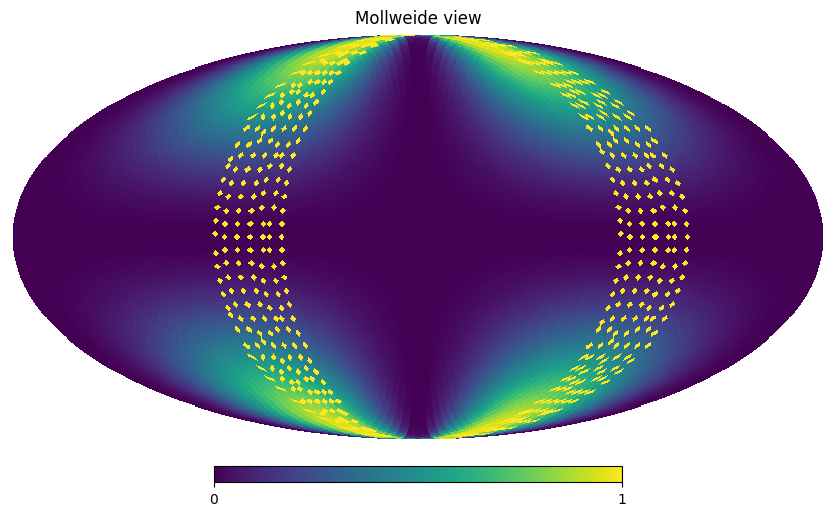

In [280]:
default_th = DEFAULT_BEAM_TH.copy()
default_ph = DEFAULT_BEAM_PHI.copy()

calc_coords = px_th_ph(rx_ant_test, tx_ant_test, az[:stop], el[:stop])

calc_coords = tuple( x.astype(jnp.int32) if i == 3 else x
            for i, x in enumerate(calc_coords) )
pxs = calc_coords[3]

default_th = default_th.at[pxs].set(beam_map[2])
default_ph = default_ph.at[pxs].set(beam_map[3])

healpy.mollview(default_th)
healpy.mollview(default_ph)

## Chat Only

In [508]:
# ---------------------------------------------------------------------------
# 1) Make the model method PURE (no reads/writes of internal beam arrays)
#    Add this as a method on your RX class (or make it a free function).
# ---------------------------------------------------------------------------
def power_transmitter_jax_pure(self, tx_ant, rot_m, th_tx, phi_tx, px,
                               pwr_beam_th, pwr_beam_phi):
    # Geometry is unchanged
    E_tx_rot = tx_ant.E_rotated(rot_m)
    th_hat   = self.th_hat(th_tx, phi_tx)
    phi_hat  = self.phi_hat(th_tx, phi_tx)

    E_tx_th  = jnp.dot(E_tx_rot, th_hat)
    E_tx_phi = jnp.dot(E_tx_rot, phi_hat)

    # Robust dynamic indexing when px is traced
    px = jax.lax.convert_element_type(px, jnp.int32)
    g_th  = jax.lax.dynamic_index_in_dim(pwr_beam_th,  px, axis=0, keepdims=False)
    g_phi = jax.lax.dynamic_index_in_dim(pwr_beam_phi, px, axis=0, keepdims=False)

    return g_th * (E_tx_th ** 2) + g_phi * (E_tx_phi ** 2)

# Attach to your class if you prefer method style:
# RXClass.power_transmitter_jax_pure = power_transmitter_jax_pure


# ---------------------------------------------------------------------------
# 2) Precompute coords outside of jit (your original version kept)
#    Returns: (rs, th_txs, phi_txs, pxs) with pxs as int32
# ---------------------------------------------------------------------------
def px_th_ph(rx, tx, az, el):
    n = el.shape[0]
    pxs    = jnp.zeros(n, dtype=jnp.int32)
    th_txs = jnp.zeros(n)
    phi_txs= jnp.zeros(n)
    rs     = jnp.zeros((n, 3, 3))
    for i in range(n):
        r = rx.rotation(az[i], el[i])
        th_tx, phi_tx = tx.heading_thphi(r)
        px = rx.ang2pix(th_tx, phi_tx)
        pxs     = pxs.at[i].set(px)
        th_txs  = th_txs.at[i].set(th_tx)
        phi_txs = phi_txs.at[i].set(phi_tx)
        rs      = rs.at[i].set(r)
        if (i + 1) % 100 == 0:
            print(f'Collecting Coords: {i+1}/{n}')
    print('Finished Calculating Coords')
    return rs, th_txs, phi_txs, pxs


# ---------------------------------------------------------------------------
# 3) Loss that updates beam arrays FUNCTIONALLY and returns them as aux
# ---------------------------------------------------------------------------
def loss_with_aux(W, P, coord, pbt, pbp, rx):
    e1, e2, th, ph = W                 # scalars (0-D JAX arrays)
    r, th_tx, phi_tx, px = coord       # r:(3,3), the rest scalars
    px = jax.lax.convert_element_type(px, jnp.int32)

    # Functional updates to the beam arrays at this px
    pbt_next = pbt.at[px].set(th)
    pbp_next = pbp.at[px].set(ph)

    # Build per-step transmitter from W
    tx_step = TransmitterAntenna(E1=e1, E2=e2)

    # PURE forward — pass the updated beam arrays explicitly
    model = rx.power_transmitter_jax_pure(
        tx_step, r, th_tx, phi_tx, px,
        pwr_beam_th=pbt_next,
        pwr_beam_phi=pbp_next
    )

    loss = jnp.mean((model - P) ** 2)
    return loss, (pbt_next, pbp_next)


# ---------------------------------------------------------------------------
# 4) A compiled "train N steps" using lax.fori_loop (inner loop)
#    Carries (W, opt_state, pbt, pbp). Prints every 'print_every' steps.
# ---------------------------------------------------------------------------
def make_trainer(optimizer, rx, steps: int = 500, print_every: int = 100):
    def train_once(W0, Pj, coord_j, pbt0, pbp0):
        opt_state0 = optimizer.init(W0)

        def body(i, carry):
            W, opt_state, pbt, pbp = carry

            (loss, (pbt_next, pbp_next)), grads = jax.value_and_grad(
                lambda W_: loss_with_aux(W_, Pj, coord_j, pbt, pbp, rx),
                has_aux=True
            )(W)

            updates, opt_state = optimizer.update(grads, opt_state, W)
            W = optax.apply_updates(W, updates)

            # Optional debug print inside jit (safe)
            jax.lax.cond(
                jnp.equal((i + 1) % print_every, 0),
                lambda _: jax.debug.print("step {i:4d} | loss {l:.6f}", i=i+1, l=loss),
                lambda _: None,
                operand=None,
            )
            return (W, opt_state, pbt_next, pbp_next)

        Wf, opt_statef, pbtf, pbpf = jax.lax.fori_loop(0, steps, body, (W0, opt_state0, pbt0, pbp0))
        # Optional final loss:
        lf, _ = loss_with_aux(Wf, Pj, coord_j, pbtf, pbpf, rx)
        return Wf, opt_statef, pbtf, pbpf, lf

    return jax.jit(train_once)


# ---------------------------------------------------------------------------
# 5) High-level driver: iterates over j (columns), runs compiled inner loop
# ---------------------------------------------------------------------------
def beam_finder(tx, rx, P, az, el, guesses):
    # Precompute coords (px_th_ph uses Python loops; that’s fine here)
    coords = px_th_ph(rx, tx, az, el)      # (rs, th_txs, phi_txs, pxs)
    # Ensure pxs are int32 (px_th_ph already does this; keeping defensively)
    coords = (coords[0], coords[1], coords[2], coords[3].astype(jnp.int32))

    # Copy base beam arrays once; carry & update them across j
    pwr_beam_th = rx.pwr_beam_th.copy()
    pwr_beam_ph = rx.pwr_beam_phi.copy()

    # Optimizer and compiled trainer
    opt = optax.adam(1e-2)
    trainer = make_trainer(opt, rx, steps=2000, print_every=1000)

    # guesses has shape (4, N); we solve column-by-column
    W  = guesses
    Ws = jnp.zeros_like(W)

    n = el.shape[0]
    for j in range(n):
        w0 = W[:, j]                                   # (4,)
        Pj = P[j]
        coord_j = jax.tree_map(lambda x: x[j], coords) # (r_j, th_tx_j, phi_tx_j, px_j)

        # Run 500 Adam steps in compiled JAX
        w, _, pwr_beam_th, pwr_beam_ph, final_loss = trainer(
            w0, Pj, coord_j, pwr_beam_th, pwr_beam_ph
        )

        Ws = Ws.at[:, j].set(w)
        print(f'finished j={j}, loss={float(final_loss):.6f}')

    # Return per-column solutions and the final beam arrays
    return Ws, pwr_beam_th, pwr_beam_ph


In [301]:
rx_ant_test = RotatingAntenna()
tx_ant_test = TransmitterAntenna(E1=1, E2=0)
g_e1 = jnp.ones(el.shape[0]) * 2
g_e2 = jnp.ones(el.shape[0]) * 0
g_th = jnp.ones(el.shape[0])
g_ph = jnp.ones(el.shape[0])
g_W = jnp.stack((g_e1, g_e2, g_th, g_ph), axis=0)
fake_ones = jnp.ones_like(el)
beam_map = beam_finder(tx_ant_test, rx_ant_test, fake_ones, az, el, g_W)

/tmp/ipykernel_236399/3751696831.py:11: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  rm = jnp.array([[x*xC+c, xyC-zs, zxC+ys],
/tmp/ipykernel_236399/3751696831.py:32: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.array([th,phi], dtype=jnp.double)


Finished Calculating Coords
step 1000 | loss 0.000000
step 2000 | loss 0.000000
finished j=0, loss=0.000000
step 1000 | loss 0.000000
step 2000 | loss 0.000000
finished j=1, loss=0.000000
step 1000 | loss 0.000000
step 2000 | loss 0.000000
finished j=2, loss=0.000000
step 1000 | loss 0.000000
step 2000 | loss 0.000000
finished j=3, loss=0.000000
step 1000 | loss 0.000000
step 2000 | loss 0.000000
finished j=4, loss=0.000000
step 1000 | loss 0.000000
step 2000 | loss 0.000000
finished j=5, loss=0.000000
step 1000 | loss 0.000000
step 2000 | loss 0.000000
finished j=6, loss=0.000000
step 1000 | loss 0.000000
step 2000 | loss 0.000000
finished j=7, loss=0.000000
step 1000 | loss 0.000000
step 2000 | loss 0.000000
finished j=8, loss=0.000000
step 1000 | loss 0.000000
step 2000 | loss 0.000000
finished j=9, loss=0.000000
step 1000 | loss 0.000000
step 2000 | loss 0.000000
finished j=10, loss=0.000000
step 1000 | loss 0.000000
step 2000 | loss 0.000000
finished j=11, loss=0.000000
step 1000 

In [299]:
beam_map[0].shape

(4, 5184)

In [509]:
def simulate_powers_vmap(rx, tx, az, el, E1, E2, pwr_beam_th=None, pwr_beam_phi=None):
    if pwr_beam_th is None: pwr_beam_th = rx.pwr_beam_th
    if pwr_beam_phi is None: pwr_beam_phi = rx.pwr_beam_phi

    # Precompute geometry for all samples (your helper)
    rs, th_txs, phi_txs, pxs = px_th_ph(rx, tx, az, el)  # pxs should already be int32

    tx_ant = TransmitterAntenna(E1=E1, E2=E2)

    def _forward(r, th_tx, phi_tx, px):
        return rx.power_transmitter_jax_pure(
            tx_ant, r, th_tx, phi_tx, px,
            pwr_beam_th=pwr_beam_th,
            pwr_beam_phi=pwr_beam_phi
        )

    # Vectorize over the sample dimension
    P = jax.vmap(_forward)(rs, th_txs, phi_txs, pxs)     # shape: (N,)
    return P
txe1 = 1
txe2 = 0
rx_target = RotatingAntenna()
tx_target = TransmitterAntenna(E1=txe1, E2=txe2)
target_p = simulate_powers_vmap(rx_target, tx_target, az, el, E1=txe1, E2=txe2)

/tmp/ipykernel_236399/3751696831.py:11: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  rm = jnp.array([[x*xC+c, xyC-zs, zxC+ys],
/tmp/ipykernel_236399/3751696831.py:32: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.array([th,phi], dtype=jnp.double)


Finished Calculating Coords


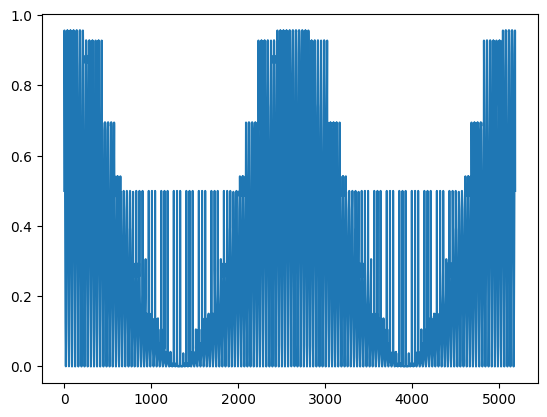

In [510]:
import matplotlib.pyplot as plt
plt.figure()
# plt.plot(target_P)
plt.plot(target_p)
plt.show()

In [511]:
th_guess.shape, g_e2.shape, calc_coords[0].shape, diff_th.shape, pxs.shape, az.shape

((5184,), (5184,), (500, 3, 3), (12288,), (5184,), (5184,))

In [512]:
# diff_th = jnp.sin(th)**2 + jnp.sin(phi)**2
# diff_ph = jnp.sin(th)**2 + jnp.cos(phi)**2
diff_th = jnp.ones_like(DEFAULT_BEAM_TH)
diff_ph = jnp.ones_like(DEFAULT_BEAM_PHI)
rx_diff = RotatingAntenna(beam_th=diff_th, beam_phi=diff_ph)
tx_diff = TransmitterAntenna(E1=txe1, E2=txe2)
guess_coord = px_th_ph(rx_diff, tx_diff, az, el)
guess_coords = tuple( x.astype(jnp.int32) if i == 3 else x
            for i, x in enumerate(guess_coord) )
pxs = guess_coords[3]


# diff_th_px = default_th.at[pxs].set(beam_map[2])
# diff_ph_px = default_ph.at[pxs].set(beam_map[3])
th_guess = diff_th[pxs]
ph_guess = diff_ph[pxs]
g_e1 = jnp.full(el.shape[0], txe1)
g_e2 = jnp.full(el.shape[0], txe2)
g_W = jnp.stack((g_e1, g_e2, th_guess, ph_guess), axis=0)
fake_ones = jnp.ones_like(el)
diff_beam_map = beam_finder(tx_diff, rx_diff, target_p, az, el, g_W)



/tmp/ipykernel_236399/3751696831.py:11: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  rm = jnp.array([[x*xC+c, xyC-zs, zxC+ys],
/tmp/ipykernel_236399/3751696831.py:32: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.array([th,phi], dtype=jnp.double)


Finished Calculating Coords


/tmp/ipykernel_236399/3751696831.py:11: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  rm = jnp.array([[x*xC+c, xyC-zs, zxC+ys],
/tmp/ipykernel_236399/3751696831.py:32: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.array([th,phi], dtype=jnp.double)


Finished Calculating Coords
step 1000 | loss 0.073028
step 2000 | loss 0.018123
finished j=0, loss=0.018095
step 1000 | loss 0.000000
step 2000 | loss 0.000000
finished j=1, loss=0.000000
step 1000 | loss 0.000000
step 2000 | loss 0.000000
finished j=2, loss=0.000000
step 1000 | loss 0.000000
step 2000 | loss 0.000000
finished j=3, loss=0.000000
step 1000 | loss 0.000004
step 2000 | loss 0.000000
finished j=4, loss=0.000000
step 1000 | loss 0.000303
step 2000 | loss 0.000000
finished j=5, loss=0.000000
step 1000 | loss 0.004823
step 2000 | loss 0.000068
finished j=6, loss=0.000068
step 1000 | loss 0.016188
step 2000 | loss 0.001088
finished j=7, loss=0.001084
step 1000 | loss 0.038214
step 2000 | loss 0.005883
finished j=8, loss=0.005870
step 1000 | loss 0.073090
step 2000 | loss 0.018149
finished j=9, loss=0.018121
step 1000 | loss 0.121135
step 2000 | loss 0.040387
finished j=10, loss=0.040339
step 1000 | loss 0.197682
step 2000 | loss 0.082955
finished j=11, loss=0.082880
step 1000 

In [513]:
# healpy.mollview(diff_beam_map[1], cmap='plasma', title='solved theta map')
# healpy.mollview(DEFAULT_BEAM_TH , cmap='plasma', title='default theta map')
# healpy.mollview(diff_th ,         cmap='plasma', title='starting theta map')
# healpy.mollview(diff_beam_map[2], cmap='plasma', title='solved phi map')
# healpy.mollview(DEFAULT_BEAM_PHI, cmap='plasma', title='default phi map')
# healpy.mollview(diff_ph ,         cmap='plasma', title='starting phi map')

In [514]:
# perc_ph = ((DEFAULT_BEAM_PHI[pxs] - diff_beam_map[2][pxs]) / DEFAULT_BEAM_PHI[pxs]) * 100
# perc_th = ((DEFAULT_BEAM_TH[pxs] - diff_beam_map[1][pxs]) / DEFAULT_BEAM_TH[pxs]) * 100

# plt.figure()
# plt.plot(perc_ph)
# # # plt.plot(perc_th)
# plt.show()

In [515]:
# plt.figure()
# plt.plot(diff_beam_map[0][0, :])
# plt.plot(diff_beam_map[0][1, :])
# plt.show()

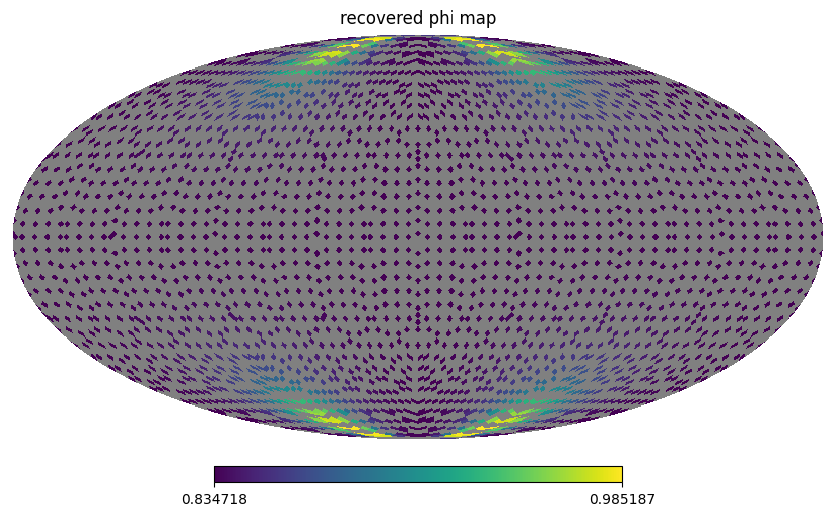

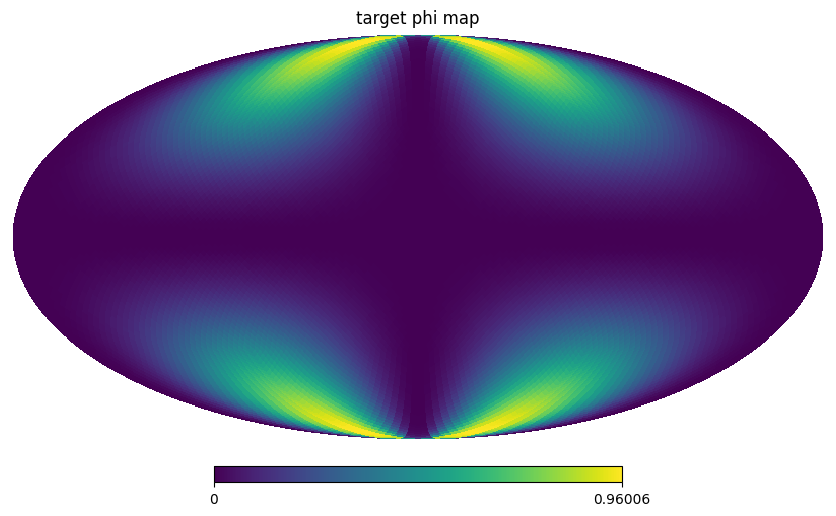

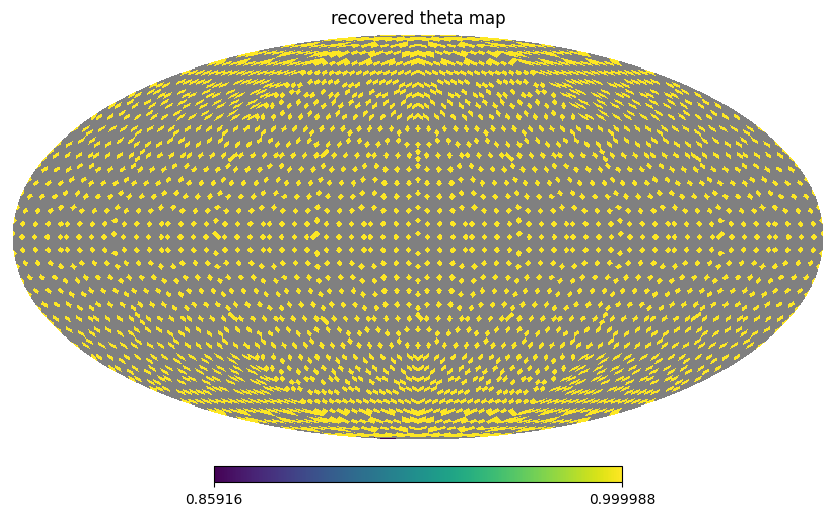

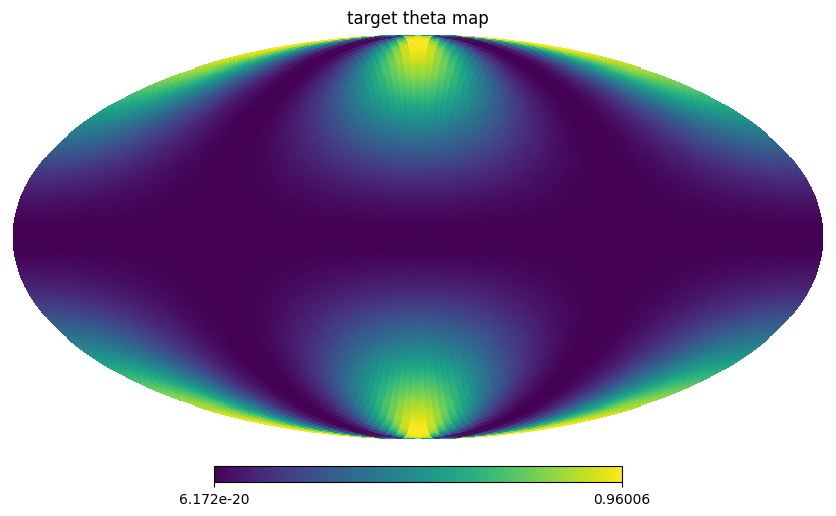

In [516]:

# empty_map = np.full(npix, healpy.UNSEEN, dtype=dtype_r)
empty_map_ph = np.full_like(DEFAULT_BEAM_PHI, healpy.UNSEEN)
empty_map_ph[pxs] = diff_beam_map[0][3, :]
empty_map_th = np.full_like(DEFAULT_BEAM_TH, healpy.UNSEEN)
empty_map_th[pxs] = diff_beam_map[0][2, :]
# empty_map = jnp.empty_like(DEFAULT_BEAM_TH)
# empty_map = empty_map.at[pxs].set(diff_beam_map[0][2, :])
healpy.mollview(empty_map_ph    , title='recovered phi map')
healpy.mollview(DEFAULT_BEAM_PHI, title='target phi map')
healpy.mollview(empty_map_th    , title='recovered theta map', rot=(90, 0, 0))
healpy.mollview(DEFAULT_BEAM_TH , title='target theta map')

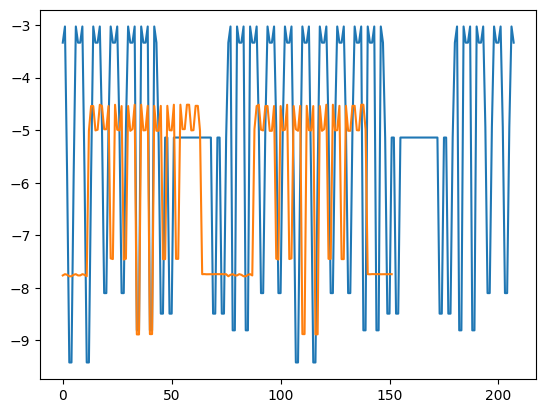

In [517]:
perc_ph = ((DEFAULT_BEAM_PHI[pxs] - empty_map_ph[pxs]) / DEFAULT_BEAM_PHI[pxs]) * 100
perc_th = ((DEFAULT_BEAM_TH[pxs] -  empty_map_th[pxs]) / DEFAULT_BEAM_TH[pxs]) * 100

plt.figure()
#plt.plot(perc_ph)
plt.plot(perc_ph[np.where(perc_ph>-10)])
plt.plot(perc_th[np.where(perc_th>-10)])
plt.show()